In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense,LSTM
import matplotlib.pyplot as plt
seed = 7
np.random.seed(seed)

In [2]:

data = pd.read_csv("Indiacases1.csv")

In [3]:
def parse(x):
     
    return pd.to_datetime(data['date'])

data = pd.read_csv('Indiacases1.csv',  parse_dates = ['date'], index_col=0, date_parser=parse)
data.index.name = 'date'
data.head()

,new_cases,new/total,growth rate,total_cases
date,,,,
2020-01-23,0,0.0,0.0,0
2020-01-24,0,0.0,0.0,0
2020-01-25,0,0.0,0.0,0
2020-01-26,0,0.0,0.0,0
2020-01-27,0,0.0,0.0,0


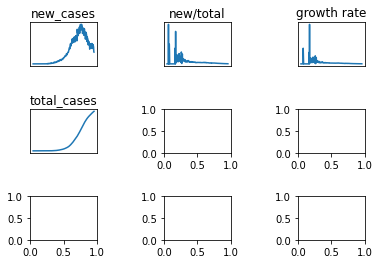

In [4]:
groups = [0, 1, 2, 3]
values = data.values
fig,sub = plt.subplots(3,3)
plt.subplots_adjust(wspace=1, hspace=1)

for ax, i in zip(sub.flatten(),groups):
    ax.plot(values[:,i])
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(data.columns[i])

In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)
scaled[0]

array([0., 0., 0., 0.])

In [6]:
def to_supervised(data,dropNa = True,lag = 1):
    df = pd.DataFrame(data)
    column = []
    column.append(df)
    for i in range(1,lag+1):
        column.append(df.shift(-i))
    df = pd.concat(column,axis=1)
    df.dropna(inplace = True)
    features = data.shape[1]
    df = df.values
    supervised_data = df[:,:features*lag]
    supervised_data = np.column_stack( [supervised_data, df[:,features*lag]])
    return supervised_data

In [7]:
timeSteps = 21

supervised = to_supervised(scaled,lag=timeSteps)
pd.DataFrame(supervised).head(100)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000010,1.000000,0.000000,1.126851e-07,0.000000,0.000000,0.000000,1.126851e-07,0.000000,0.000000,0.000000,1.126851e-07,...,0.500000,0.395454,3.380552e-07,0.000000,0.333333,0.230216,3.380552e-07,0.000000,0.000000,0.000000,3.380552e-07,0.000000,0.000000,0.000000,3.380552e-07,0.000000,0.000000,0.000000,3.380552e-07,0.000000,0.000000,0.000000,3.380552e-07,0.000000,0.000000,0.000000,3.380552e-07,0.000000,0.000000,0.000000,3.380552e-07,0.000000,0.000000,0.000000,3.380552e-07,0.000000,0.000000,0.000000,3.380552e-07,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000010,1.000000,0.000000,1.126851e-07,0.000000,0.000000,0.000000,1.126851e-07,0.000000,0.000000,0.000000,1.126851e-07,0.000010,0.000000,0.000000,2.253701e-07,...,0.333333,0.230216,3.380552e-07,0.000000,0.000000,0.000000,3.380552e-07,0.000000,0.000000,0.000000,3.380552e-07,0.000000,0.000000,0.000000,3.380552e-07,0.000000,0.000000,0.000000,3.380552e-07,0.000000,0.000000,0.000000,3.380552e-07,0.000000,0.000000,0.000000,3.380552e-07,0.000000,0.000000,0.000000,3.380552e-07,0.000000,0.000000,0.000000,3.380552e-07,0.000000,0.000000,0.000000,3.380552e-07,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000010,1.000000,0.000000,1.126851e-07,0.000000,0.000000,0.000000,1.126851e-07,0.000000,0.000000,0.000000,1.126851e-07,0.000010,0.000000,0.000000,2.253701e-07,0.000010,0.500000,0.395454,3.380552e-07,...,0.000000,0.000000,3.380552e-07,0.000000,0.000000,0.000000,3.380552e-07,0.000000,0.000000,0.000000,3.380552e-07,0.000000,0.000000,0.000000,3.380552e-07,0.000000,0.000000,0.000000,3.380552e-07,0.000000,0.000000,0.000000,3.380552e-07,0.000000,0.000000,0.000000,3.380552e-07,0.000000,0.000000,0.000000,3.380552e-07,0.000000,0.000000,0.000000,3.380552e-07,0.000000,0.000000,0.000000,3.380552e-07,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000010,1.000000,0.000000,1.126851e-07,0.000000,0.000000,0.000000,1.126851e-07,0.000000,0.000000,0.000000,1.126851e-07,0.000010,0.000000,0.000000,2.253701e-07,0.000010,0.500000,0.395454,3.380552e-07,0.000000,0.333333,0.230216,3.380552e-07,...,0.000000,0.000000,3.380552e-07,0.000000,0.000000,0.000000,3.380552e-07,0.000000,0.000000,0.000000,3.380552e-07,0.000000,0.000000,0.000000,3.380552e-07,0.000000,0.000000,0.000000,3.380552e-07,0.000000,0.000000,0.000000,3.380552e-07,0.000000,0.000000,0.000000,3.380552e-07,0.000000,0.000000,0.000000,3.380552e-07,0.000000,0.000000,0.000000,3.380552e-07,0.000000,0.000000,0.000000,3.380552e-07,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000010,1.000000,0.000000,1.126851e-07,0.000000,0.000000,0.000000,1.126851e-07,0.000000,0.000000,0.000000,1.126851e-07,0.000010,0.000000,0.000000,2.253701e-07,0.000010,0.500000,0.395454,3.380552e-07,0.000000,0.333333,0.230216,3.380552e-07,0.000000,0.000000,0.000000,3.380552e-07,...,0.000000,0.000000,3.380552e-07,0.000000,0.000000,0.000000,3.380552e-07,0.000000,0.000000,0.000000,3.380552e-07,0.000000,0.000000,0.000000,3.380552e-07,0.000000,0.000000,0.000000,3.380552e-07,0.00

In [8]:
features = data.shape[1]
train_hours = 257
X = supervised[:,:features*timeSteps]
y = supervised[:,features*timeSteps]

x_train = X[:train_hours,:]
x_test = X[train_hours:,:]
y_train = y[:train_hours]
y_test = y[train_hours:]

print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(257, 84) (21, 84) (257,) (21,)


In [9]:
x_train = x_train.reshape(x_train.shape[0], timeSteps, features)
x_test = x_test.reshape(x_test.shape[0], timeSteps, features)

print(x_train.shape,x_test.shape)

(257, 21, 4) (21, 21, 4)


In [10]:
model = Sequential()
model.add( LSTM( 50, input_shape = ( timeSteps,x_train.shape[2]) ) )
model.add( Dense(1) )

model.compile( loss = "mae", optimizer = "adam")

history =  model.fit( x_train,y_train, validation_data = (x_test,y_test), epochs = 3000 , batch_size = 30, verbose = 1, shuffle = False)

Streaming output truncated to the last 5000 lines.
Epoch 501/3000
9/9 [==============================] - 0s 15ms/step - loss: 0.0112 - val_loss: 0.0544
Epoch 502/3000
9/9 [==============================] - 0s 14ms/step - loss: 0.0114 - val_loss: 0.0683
Epoch 503/3000
9/9 [==============================] - 0s 15ms/step - loss: 0.0102 - val_loss: 0.0526
Epoch 504/3000
9/9 [==============================] - 0s 16ms/step - loss: 0.0098 - val_loss: 0.0738
Epoch 505/3000
9/9 [==============================] - 0s 15ms/step - loss: 0.0109 - val_loss: 0.0552
Epoch 506/3000
9/9 [==============================] - 0s 14ms/step - loss: 0.0106 - val_loss: 0.0646
Epoch 507/3000
9/9 [==============================] - 0s 14ms/step - loss: 0.0104 - val_loss: 0.0537
Epoch 508/3000
9/9 [==============================] - 0s 15ms/step - loss: 0.0120 - val_loss: 0.0650
Epoch 509/3000
9/9 [==============================] - 0s 15ms/step - loss: 0.0114 - val_loss: 0.0509
Epoch 510/3000
9/9 [====================

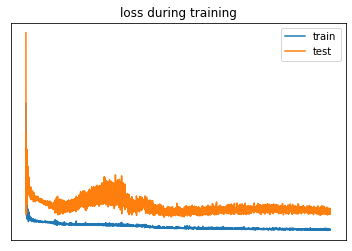

In [11]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.yticks([])
plt.xticks([])
plt.title("loss during training")
plt.show()

In [12]:
y_pred = model.predict(x_test)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[2]*x_test.shape[1])
forecast_copies = np.repeat(y_pred, 3, axis=-1)
inv_new = np.concatenate( (y_pred,x_test[:,0:3]  ) , axis =1)
inv_new = scaler.inverse_transform(inv_new)[:,0]
final_pred = inv_new


y_test = y_test.reshape( len(y_test), 1)
forecast_copies = np.repeat(y_test, 3, axis=-1)
inv_new = np.concatenate( (y_test,x_test[:,0:3]  ) , axis =1)
inv_new = scaler.inverse_transform(inv_new)
actual_pred = inv_new[:,0]

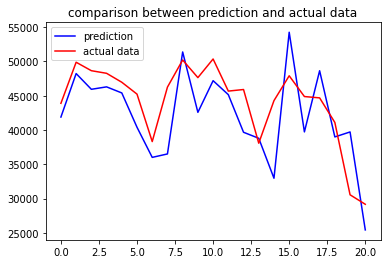

In [13]:
plt.plot(final_pred, label = "prediction",c = "b")
plt.plot(actual_pred,label = "actual data",c="r")

plt.title("comparison between prediction and actual data")
plt.legend()

In [14]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

print("means abs error" ,mean_absolute_error(final_pred,actual_pred))
print("mse" ,mean_squared_error(final_pred,actual_pred))

means abs error 4069.6266082354955
mse 25426634.559960097
